# Detecção de Doenças em Plantas usando FastAI

A biblioteca FastAI é uma revolução na maneira de fazer AI. Seja pela maneira como os códigos dessa foram desenvolvidos visando uma abordagem _user_ _friendly_ quanto nas aulas [disponibilizadas gratuitamente](https://www.fast.ai/) pelos desenvolvedores Jeremy Howard e Rachel Thomas. Após assistir a primeira aula do curso _Practical Deep Learning for Coders_ já é possivel criar uma rede neural de convolução para classificar imagens com uma excelente acurácia de predição. Esse post vai seguir os ideais hands-on do curso e será tipo um tutorial desenvolvido depois de assistir somente à primeira aula e à excelente aula do Pierre. Aqui discutirei o porque da escolha do dataset, problemas em importar o dataset, ferramentas auxiliares e, finalmente, o treinamento de um modelo que alcançou 99.3% de acurácia num dataset contendo 21 categorias para discernir plantas saudáveis e 20 tipos de doenças de plantas a partir de fotos das suas folhas.



In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

from pathlib import Path
import os

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

## Escolhendo o Dataset

A primeira etapa em qualquer projeto de ciência de dados é a escolha e manipulação do dataset a ser usado no problema. O dataset deve conter informação suficiente para responder a hipótese proposta. Podemos encontrar diversos datasets públicos na sessão [datasets do site do kaggle](https://www.kaggle.com/datasets).

Como o objetivo é criar um classificador de imagens a partir da fastai, eu restringi a busca para datasets contendo imagens. Além disso, meu principal interesse (mas não único) é usar machine learning para resolver problemas envolvendo questões biológicas. Portanto, com isso em mente eu me deparei com o dataset [PlantVillage](https://www.kaggle.com/emmarex/plantdisease).

O Plant Village é um dataset com 54.000 imagens de folhas de diversas plantas. O dataset pode ser separado em folhas saudáveis ou doentes. As folhas doentes apresentam alguma patologia, alterando sua superfície. O dataset possui imagens de folhas com patologias diferentes entre 14 culturas de plantas.

Muitas vezes negligenciadas, as doenças que acometem as plantas podem ter severas consequências para os seres humanos. Estima-se que 90% das calorias ingeridas no mundo são oriundas de 15 tipos de culturas de plantas. Portanto, se uma epidemia atingir ao menos uma dessas culturas sabe-se que grande parte da população do mundo não terá comida o suficiente.


O dataset será baixado através da [api do kaggle](https://github.com/Kaggle/kaggle-api) que pode ser instalada diretamente pelo `jupyter notebook`. Mas, antes disso devemos configurar a api para reconhecer nossas credenciais de acesso ao kaggle. Isso pode ser feito exportando-se o username e password gerados pelo kaggle nas variáveis de ambiente, como mostrado no github da api. A maneira de acessar as credenciais do kaggle escolhida foi usando o arquivo `kaggle.json` que pode ser baixado através da plataforma. Depois de baixar ele eu hospedei no meu gdrive e quando desejo executar a api do kaggle eu faço o loading do json no meu ambiente do jupyter notebook e dou as permissões de acesso ao servidor do kaggle.

In [0]:
import gdown

def download(id):
  url = 'https://drive.google.com/uc?id=' + str(id)
  gdown.download(url, output = None, quiet = True)

download('1j94EBZxZdcZl5m9UKYspLazsEXQniv9H')

root = Path('/content')
kaggle = root/'.kaggle'
kaggle.mkdir()

In [0]:
! mv {root}'/kaggle.json' {kaggle}

In [0]:
!chmod 600 /content/.kaggle/kaggle.json

In [0]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/.kaggle'

Ao executarmos o comando abaixo, certifique-se de não receber nenhuma mensagem de erro. Apenas o help do comando executado. Caso alguma mensagem de erro apareça, muito possivelmente é um indicativo que as permissões de acesso à api do kaggle não foram configuradas corretamente. Checar o [github da api](https://github.com/Kaggle/kaggle-api) para maiores informações.

In [7]:
! kaggle  -h

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...

optional arguments:
  -h, --help            show this help message and exit
  -v, --version         show program's version number and exit

commands:
  {competitions,c,datasets,d,kernels,k,config}
                        Use one of:
                        competitions {list, files, download, submit, submissions, leaderboard}
                        datasets {list, files, download, create, version, init, metadata, status}
                        config {view, set, unset}
    competitions        Commands related to Kaggle competitions
    datasets            Commands related to Kaggle datasets
    kernels             Commands related to Kaggle kernels
    config              Configuration settings


O api da kaggle possui o módulo `datasets` com comandos úteis para baixar os conjuntos de dados hospedados no site. A seguir o `help` deste módulo é mostrado.

In [8]:
! kaggle datasets -h

usage: kaggle datasets [-h]
                       {list,files,download,create,version,init,metadata,status}
                       ...

optional arguments:
  -h, --help            show this help message and exit

commands:
  {list,files,download,create,version,init,metadata,status}
    list                List available datasets
    files               List dataset files
    download            Download dataset files
    create              Create a new dataset
    version             Create a new dataset version
    init                Initialize metadata file for dataset creation
    metadata            Download metadata about a dataset
    status              Get the creation status for a dataset


Logo, para fazer o download de um dataset devemos acessar o comando `kaggle datasets download` que possui as seguintes opções:

In [9]:
! kaggle datasets download -h

usage: kaggle datasets download [-h] [-f FILE_NAME] [-p PATH] [-w] [--unzip]
                                [-o] [-q]
                                [dataset]

optional arguments:
  -h, --help            show this help message and exit
  dataset               Dataset URL suffix in format <owner>/<dataset-name> (use "kaggle datasets list" to show options)
  -f FILE_NAME, --file FILE_NAME
                        File name, all files downloaded if not provided
                        (use "kaggle datasets files -d <dataset>" to show options)
  -p PATH, --path PATH  Folder where file(s) will be downloaded, defaults to current working directory
  -w, --wp              Download files to current working path
  --unzip               Unzip the downloaded file. Will delete the zip file when completed.
  -o, --force           Skip check whether local version of file is up to date, force file download
  -q, --quiet           Suppress printing information about the upload/download progress


A url do dataset PlantVillage é https://www.kaggle.com/saroz014/plant-disease, onde podemos pegar o sufixo `saroz014/plant-disease` como a chave para fazer o download deste dataset. Além disso, após o download vamos especificar que queremos a descompactação dos dados baixados. Antes disso, criamos a pasta `ds` que será o destino dos dados baixados.

In [0]:
root = Path('/content');
ds_folder = root/'ds'
ds_folder.mkdir(exist_ok=True)

In [12]:
! kaggle datasets download -p {ds_folder} --unzip saroz014/plant-disease

100% 1.59G/1.60G [00:15<00:00, 115MB/s]
100% 1.60G/1.60G [00:15<00:00, 108MB/s]


Ao listar a estrutura das pastas podemos observar que as imagens encontram-se distribuidas ao longo de diversas pastas cujos títulos indicam o nome e condição de cada planta contida no dataset. Logo, as classes podem ser obtidas a partir do título das pastas. O nome das plantas pode ser ignorado pois o objetivo do classificador é determinar se uma determinada planta encontra-se doente e qual a sua doença.

In [35]:
! ls {ds_folder}/dataset/dataset/

test  train


Dentro da pasta `test/` podemos ver as subpastas com as classes.

In [36]:
! ls {ds_folder}/dataset/dataset/test

 Apple___Apple_scab
 Apple___Black_rot
 Apple___Cedar_apple_rust
 Apple___healthy
 Blueberry___healthy
'Cherry_(including_sour)___healthy'
'Cherry_(including_sour)___Powdery_mildew'
'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
'Corn_(maize)___Common_rust_'
'Corn_(maize)___healthy'
'Corn_(maize)___Northern_Leaf_Blight'
 Grape___Black_rot
'Grape___Esca_(Black_Measles)'
 Grape___healthy
'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
'Orange___Haunglongbing_(Citrus_greening)'
 Peach___Bacterial_spot
 Peach___healthy
 Pepper,_bell___Bacterial_spot
 Pepper,_bell___healthy
 Potato___Early_blight
 Potato___healthy
 Potato___Late_blight
 Raspberry___healthy
 Soybean___healthy
 Squash___Powdery_mildew
 Strawberry___healthy
 Strawberry___Leaf_scorch
 Tomato___Bacterial_spot
 Tomato___Early_blight
 Tomato___healthy
 Tomato___Late_blight
 Tomato___Leaf_Mold
 Tomato___Septoria_leaf_spot
'Tomato___Spider_mites Two-spotted_spider_mite'
 Tomato___Target_Spot
 Tomato___Tomato_mosaic_virus
 Tomato_

## Carregando o dataset no FastAI

Parece que existe uma quase regularidade no título das subpastas. Temos o nome da planta (ex: Potato, Tomato, ...) seguido por 3 subescritos (`_`) e, pela condição patológica da folha (ex: healthy, Early_blight, ...). Portanto vamos usar uma expressão regular para separar as imagens pelas condições patológicas juntanto as imagens de plantas diferentes porém com a mesma condição patológica.

Para isso, a biblioteca `Fastai` possui uma funcionalidade muito útil para extrair o nome das classes a partir do caminho (path) das imagens. Essa funcionalidade pode ser executada a partir do método `ImageDataBunch.from_name_re()` e usa expressões regulares para extrair os nomes das classes.

Antes de aplicar a expressão regular vamos pegar os caminhos de todas as imagens do dataset Plant Disease e armazenar numa lista. Mais uma vez, essa tarefa é extremamente fácil, com o uso da função `get_images()` da fastai.

A seguinte linha armazena o caminho de todas as imagens do dataset. Note que colocou-se `recurse=True` para permitir que a função busca todas as imagens, inclusive as contidas nos subdiretórios.

In [0]:
path_img = ds_folder/'dataset/dataset/'

In [41]:
fnames = get_image_files(path_img, recurse=True);
fnames[:10]

[PosixPath('/content/ds/dataset/dataset/train/Raspberry___healthy/b93108ac-bbc8-4fcd-9bae-9514ec2f3127___Mary_HL 6326.JPG'),
 PosixPath('/content/ds/dataset/dataset/train/Raspberry___healthy/69de5784-3876-4928-80b9-43245d16d54d___Mary_HL 6341.JPG'),
 PosixPath('/content/ds/dataset/dataset/train/Raspberry___healthy/5829c049-aa10-494a-9663-8ce0677e64f7___Mary_HL 6330.JPG'),
 PosixPath('/content/ds/dataset/dataset/train/Raspberry___healthy/a1b6a479-3698-4370-a7b1-a43ca44eb027___Mary_HL 6223.JPG'),
 PosixPath('/content/ds/dataset/dataset/train/Raspberry___healthy/acf6aef9-fdb6-4cc3-bd98-2a25a7c15f55___Mary_HL 9141.JPG'),
 PosixPath('/content/ds/dataset/dataset/train/Raspberry___healthy/afe05bf6-ccef-4665-8a62-6a4a4c2d2939___Mary_HL 9239.JPG'),
 PosixPath('/content/ds/dataset/dataset/train/Raspberry___healthy/8fb1b24f-806a-40f3-abf6-a02790512dc5___Mary_HL 6232.JPG'),
 PosixPath('/content/ds/dataset/dataset/train/Raspberry___healthy/54564261-1cce-4a60-ab02-ff8b31b5e6f1___Mary_HL 6244.JPG'),


Agora que possuimos os caminhos de todas as imagens do nosso dataset devemos criar a expressão regular para extrair a informação sobre qual condição fitopatológica a imagem pertence.

Vamos escolher um exemplo para criar a expressão regular e checar se esta é válida. O exemplo é o caminho `Raspberry___healthy/b93108ac-bbc8-4fcd-9bae-9514ec2f3127___Mary_HL 6326.JPG`.

Um site muito útil para a criação de expressões regulares é o [regex 101](https://regex101.com/). Nele é possível testar uma expressão regular em tempo real através de palavras de teste. A palavra de teste é o caminho exemplo determinado acima. Lembre-se de selecionar a linguagem Python no menu à esquerda no regex 101.


![alt text](https://raw.githubusercontent.com/rodtheo/rodtheo.github.io/master/images/regex01.png)

Acima podemos checar que a expressão regular proposta faz o pareamento com a string de test e seleciona healthy como um grupo. Este grupo será a classe da imagem. Vamos copiar a expressão regular e aplicá-la ao dataset PlantVillage e criar o objeto no fastai `ImageDataBunch` que lidará com o dataset.

![alt text](https://raw.githubusercontent.com/rodtheo/rodtheo.github.io/master/images/regex02.png)

Além das extensões mencionadas, as imagens também possuem as seguintes extensões: `jpeg`, `png`. Portanto, essas extensões serão adicionadas à expressão regular usada.

In [0]:
pat = r".+___(.+)\/.+\.JPG$"

In [59]:
bs = 64
data = ImageDataBunch.from_name_re(path_img, fnames, pat,  ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

AssertionError: ignored

O erro acima indica que não foi possível aplicar o padrão regex a todas as imagens. Há uma falha ao aplicar a expressão regular na imagem com final `Pepper,_bell___healthy/3306b49b-e3b3-4450-8609-ae44ab2b6593___bell-pepper-plant-61726.jpg`. Portanto, vamos jogar essa string como exemplo no regex101 e tentar criar uma expressão regular mais adequada ao conjunto de dados. A qualidade das anotações nos datasets disponíveis publicamente é um dos maiores empecilhos. Mas após organizar corretamente o dataset veremos que aplicar a rede neural através do fastai é simples.

A seguir, verificamos que o erro na expressão regular usada anteriormente relaciona-se à extensão da imagem. No primeiro exemplo a extensão tinha final `.JPG`, em letras maiúsculas, enquanto existem algumas imagens com final `.jpg` em minúsculo.

In [0]:
pat = r".+___(.+)\/.+\.(jpg|JPG|jpeg|png)$"

In [0]:
bs = 64
data = ImageDataBunch.from_name_re(path_img, fnames, pat,  ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

Abaixo mostramos alguns exemplos das imagens e suas classes. No total, temos 21 condições de patologia diferentes. Ou seja, 21 categorias na qual devemos classificar as mais de 54000 imagens do dataset PlantVillage. Note que o tamanho do conjunto de teste é de 20% da quantidade de imagens no dataset, ou seja, aproximadamente 10.000 imagens.

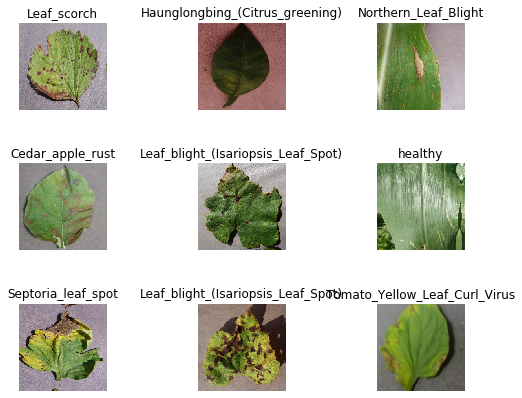

In [52]:
data.show_batch(rows=3, figsize=(7,6))

In [56]:
print(data.classes)

['Apple_scab', 'Bacterial_spot', 'Black_rot', 'Cedar_apple_rust', 'Cercospora_leaf_spot Gray_leaf_spot', 'Common_rust_', 'Early_blight', 'Esca_(Black_Measles)', 'Haunglongbing_(Citrus_greening)', 'Late_blight', 'Leaf_Mold', 'Leaf_blight_(Isariopsis_Leaf_Spot)', 'Leaf_scorch', 'Northern_Leaf_Blight', 'Powdery_mildew', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy']


## Treinando uma CNN para classificar doenças de plantas

Com o dataset encapsulado no objeto `DataBunch` do Kaggle podemos treinar nosso modelo. Vamos usar uma rede de convolução neural (CNN) através da arquitetura resnet34. Além disso, o modo de operação padrão da fastai é o transfer learning. Isto significa que o nosso modelo será treinado usando o conhecimento prévio da resnet34. Este conhecimento foi obtido através do treinamento da resnet34 pelos criadores da mesma e, como o Pierre comentou, usando mais de um 1 milhão de imagens classificadas em diversas categorias. A rede a ser treinada a seguir só aprenderá os pesos da camada de classificação, isto é, como classificar as imagens do dataset PlantVillage entre as 21 categorias de condições fitopatológicas (classes da rede).

In [64]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 67.5MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.300508,0.143871,0.049259,07:40
1,0.153946,0.064741,0.020993,07:40
2,0.096603,0.040910,0.013074,07:46
3,0.065444,0.032636,0.010404,07:40


**Wow ! A acurácia da predição do modelo foi de quase 99%**. Podemos salvar o modelo treinado usando o seguinte comando:

In [0]:
learn.save('/content/stage-1')

## Interpretando os resultados

Outra funcionalidade valiosa do FastAI é a facilidade em interpretar os resultados dos treinamentos das redes neurais. Para isso, basta criar um objeto interpretador do tipo `ClassificationInterpretation` a partir do modelo treinado. Com isso podemos plotar as imagens com piores predições. 

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

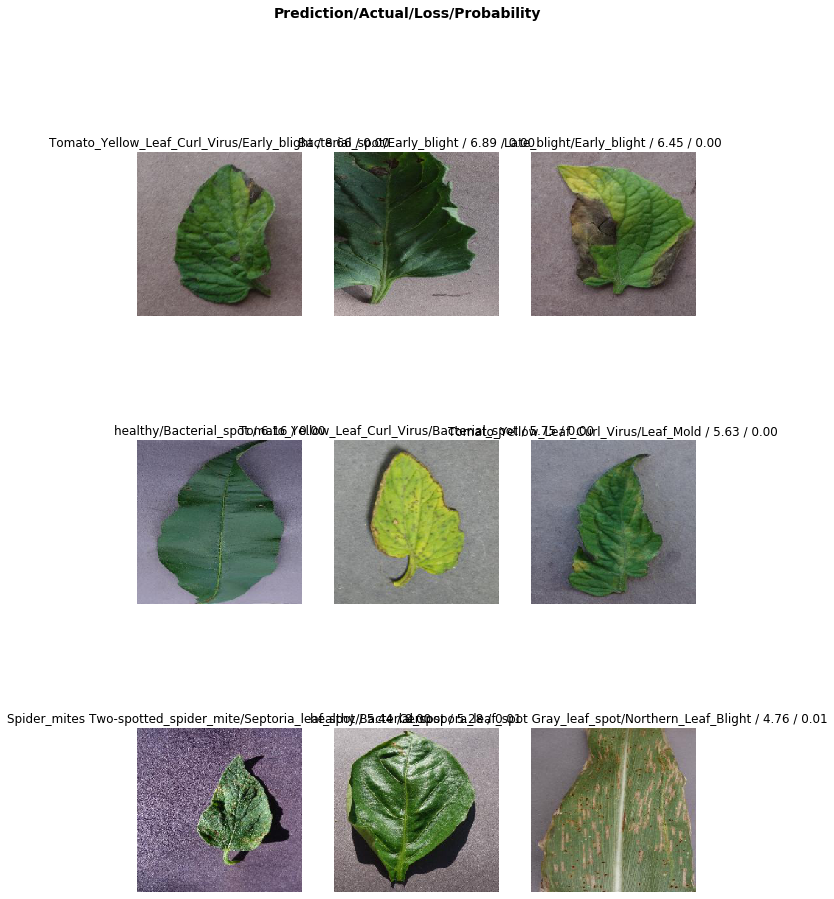

In [70]:
interp.plot_top_losses(9, figsize=(10,15))

Além disso, podemos plotar uma matriz de confusão e checar o aprendizado da rede em cada classe.

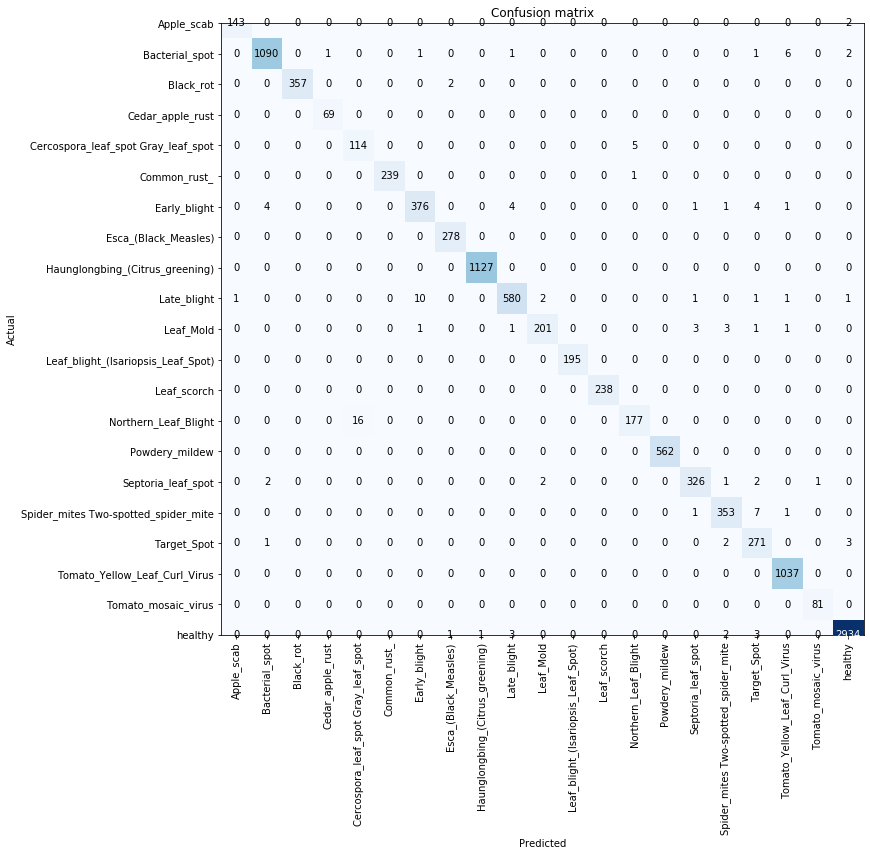

In [75]:
interp.plot_confusion_matrix(figsize=(12,15))

Repare que o modelo foi treinado com somente 4 épocas e obteve 98.9% de acurácia. Uma pergunta que pode surgir é se existem mais posibilidades para melhorar essa acurácia ? A resposta é, sim ! Uma das opções seria usar uma arquitetura de rede mais complexa, como por exemplo a `resnet50` ou mesmo treinar por mais épocas. Porém, o FastAI possui uma outra cartada na manga. E ela relaciona-se ao treinamento do modelo usando diferentes taxas de aprendizado (`learning rates`) para cada layer. A intuição de usar um gradiente de taxas de aprendizado, aumentando-se as taxas à medida que aproximam-se as camadas mais profundas da rede é justificado pelo conteúdo de aprendizado em cada camada. O conteúdo de aprendizado em cada camada, numa rede cnn usando imagens como input, nada mais é do que a geometria que as camadas aprendem. As camadas iniciais aprendem a diferenciar formas geométricas simples, como retas. E, camadas mais profundas aprendem a diferenciar formas geométricas mais complexas como por exemplo, faces inteiras ou carros completos. O fato de usar um learning rate mais baixo nas camadas iniciais e aumentá-lo progressivamente nas camadas mais profundas implica que formas geométricas básicas sempre existirão nas imagens mas, formas mais complexas não necessariamente. Poranto, vamos deixar nosso modelo aprender as formas mais complexas a partir dos nossos dados !

In [0]:
learn.unfreeze()

In [78]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


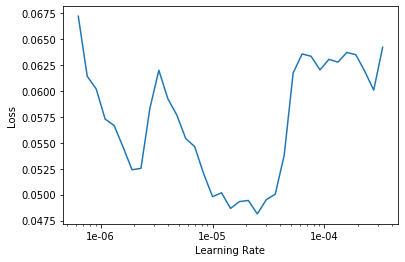

In [79]:
learn.recorder.plot()

Acima, o plot representa a taxa de aprendizado. Dele podemos tirar os valores de gradiente para aprimorar o treinamento do nosso modelo. Vou treinar a rede por mais 2 épocas com variação na taxa de aprendizado entre $10^{-5}$ e $10^{-4}$.

In [80]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.057302,0.023557,0.008563,08:12
1,0.032650,0.016935,0.006445,08:13


Como podemos ver pela taxa de erro, após o treinamento com learning rate variável por 2 épocas alcançamos uma **ACURÁCIA NAS PREDIÇÕES DE 99.3%** !!! Vamos salvar o nosso modelo abaixo e correr para o abraço !


In [0]:
learn.save('/content/final')

Acho que esses resultados mostram o poder da biblioteca FastAI e como ela vêm alterando o modo de se fazer deep learning, mudando o paradigma do machine learning teórico para uma pegada mais aplicada.

_Esse post foi escrito totalmente no jupyter notebook e rodado via plataforma google colab. Você pode baixar esse notebook ou abri-lo através do google colab._